# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "x_shape",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 50

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "source_loss"

standalone_parameters["datasets"] = [
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source",
        "x_transforms": ["unit_mag", "minus_two"],
        "episode_transforms": [],
        "domain_prefix": "ORACLE_"
    },
    {
        "labels": ALL_NODES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target",
        "x_transforms": ["unit_power", "times_zero"],
        "episode_transforms": [],
        "domain_prefix": "CORES_"
    }   
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Parameters
parameters = {
    "experiment_name": "tl_1v2:wisig-oracle.run1.limited",
    "device": "cuda",
    "lr": 0.0001,
    "n_shot": 3,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "n_way": 16,
    "datasets": [
        {
            "labels": [
                "1-10",
                "1-12",
                "1-14",
                "1-16",
                "1-18",
                "1-19",
                "1-8",
                "10-11",
                "10-17",
                "10-4",
                "10-7",
                "11-1",
                "11-10",
                "11-19",
                "11-20",
                "11-4",
                "11-7",
                "12-19",
                "12-20",
                "12-7",
                "13-14",
                "13-18",
                "13-19",
                "13-20",
                "13-3",
                "13-7",
                "14-10",
                "14-11",
                "14-12",
                "14-13",
                "14-14",
                "14-19",
                "14-20",
                "14-7",
                "14-8",
                "14-9",
                "15-1",
                "15-19",
                "15-6",
                "16-1",
                "16-16",
                "16-19",
                "16-20",
                "17-10",
                "17-11",
                "18-1",
                "18-10",
                "18-11",
                "18-12",
                "18-13",
                "18-14",
                "18-15",
                "18-16",
                "18-17",
                "18-19",
                "18-2",
                "18-20",
                "18-4",
                "18-5",
                "18-7",
                "18-8",
                "18-9",
                "19-1",
                "19-10",
                "19-11",
                "19-12",
                "19-13",
                "19-14",
                "19-15",
                "19-19",
                "19-2",
                "19-20",
                "19-3",
                "19-4",
                "19-6",
                "19-7",
                "19-8",
                "19-9",
                "2-1",
                "2-13",
                "2-15",
                "2-3",
                "2-4",
                "2-5",
                "2-6",
                "2-7",
                "2-8",
                "20-1",
                "20-12",
                "20-14",
                "20-15",
                "20-16",
                "20-18",
                "20-19",
                "20-20",
                "20-3",
                "20-4",
                "20-5",
                "20-7",
                "20-8",
                "3-1",
                "3-13",
                "3-18",
                "3-2",
                "3-8",
                "4-1",
                "4-10",
                "4-11",
                "5-1",
                "5-5",
                "6-1",
                "6-15",
                "6-6",
                "7-10",
                "7-11",
                "7-12",
                "7-13",
                "7-14",
                "7-7",
                "7-8",
                "7-9",
                "8-1",
                "8-13",
                "8-14",
                "8-18",
                "8-20",
                "8-3",
                "8-8",
                "9-1",
                "9-7",
            ],
            "domains": [1, 2, 3, 4],
            "num_examples_per_domain_per_label": -1,
            "pickle_path": "/root/csc500-main/datasets/wisig.node3-19.stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": [],
            "episode_transforms": [],
            "domain_prefix": "Wisig_",
        },
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/root/csc500-main/datasets/oracle.Run1_10kExamples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": [],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run1",
        },
    ],
    "dataset_seed": 420,
    "seed": 420,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

if "x_shape" not in p:
    p.x_shape = [2,256] # Default to this if we dont supply x_shape


supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")

In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [11]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [12]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [13]:
for ds in p.datasets:
    add_dataset(**ds)

In [14]:
# from steves_utils.CORES.utils import (
#     ALL_NODES,
#     ALL_NODES_MINIMUM_1000_EXAMPLES,
#     ALL_DAYS
# )

# add_dataset(
#     labels=ALL_NODES,
#     domains = ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"cores_{u}"
# )

In [15]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle1_{u}"
# )


In [16]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62,56}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle2_{u}"
# )

In [17]:
# add_dataset(
#     labels=list(range(19)),
#     domains = [0,1,2],
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "metehan.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"met_{u}"
# )

In [18]:
# # from steves_utils.wisig.utils import (
# #     ALL_NODES_MINIMUM_100_EXAMPLES,
# #     ALL_NODES_MINIMUM_500_EXAMPLES,
# #     ALL_NODES_MINIMUM_1000_EXAMPLES,
# #     ALL_DAYS
# # )

# import steves_utils.wisig.utils as wisig


# add_dataset(
#     labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
#     domains = wisig.ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"wisig_{u}"
# )

In [19]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [20]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'ORACLE.run132', 'ORACLE.run144', 'ORACLE.run150', 'ORACLE.run126', 'ORACLE.run18', 'ORACLE.run120', 'ORACLE.run114', 'ORACLE.run138'}


{'Wisig_3', 'Wisig_2', 'Wisig_4', 'Wisig_1'}


tensor([[[-6.1037e-04,  7.0193e-04,  1.0071e-03,  ..., -1.8921e-03,
           2.9603e-03,  3.3265e-03],
         [-2.9298e-03, -8.5452e-04,  1.3428e-03,  ..., -3.2044e-03,
          -4.2421e-03, -6.4089e-04]],

        [[-1.0376e-03,  7.0193e-04, -2.4415e-03,  ..., -1.2207e-03,
          -3.5707e-03,  2.4415e-04],
         [ 6.1037e-04, -1.5259e-03,  8.5452e-04,  ...,  3.3876e-03,
          -1.7701e-03, -1.5870e-03]],

        [[-3.1129e-03, -2.5330e-03,  8.8504e-04,  ..., -2.9908e-03,
           1.1597e-03,  2.7467e-04],
         [ 2.3499e-03, -1.5259e-03, -3.6317e-03,  ...,  4.2726e-04,
          -3.3265e-03,  2.6246e-03]],

        ...,

        [[-2.9603e-03,  1.7396e-03,  1.0681e-03,  ..., -2.1668e-03,
           2.7467e-03, -3.5401e-03],
         [-3.3876e-03,  2.0447e-03,  4.6388e-03,  ...,  3.4791e-03,
           5.3407e-03,  3.0519e-05]],

        [[-5.0661e-03,  1.3733e-03, -5.7985e-04,  ..., -6.6836e-03,
           2.9603e-03,  5.1881e-03],
         [ 3.7233e-03,  2.3194e-0

In [21]:
###################################
# Build the model
###################################
# easfsl only wants a tuple for the shape
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=tuple(p.x_shape))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [22]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 6720], examples_per_second: 32.1173, train_label_loss: 2.7336, 


epoch: 1, [batch: 672 / 6720], examples_per_second: 3943.0903, train_label_loss: 1.3429, 


epoch: 1, [batch: 1344 / 6720], examples_per_second: 3912.8617, train_label_loss: 1.3955, 


epoch: 1, [batch: 2016 / 6720], examples_per_second: 3925.8602, train_label_loss: 1.4698, 


epoch: 1, [batch: 2688 / 6720], examples_per_second: 3865.9843, train_label_loss: 1.2902, 


epoch: 1, [batch: 3360 / 6720], examples_per_second: 3909.1074, train_label_loss: 1.2593, 


epoch: 1, [batch: 4032 / 6720], examples_per_second: 3989.3842, train_label_loss: 1.2293, 


epoch: 1, [batch: 4704 / 6720], examples_per_second: 3897.9710, train_label_loss: 1.2033, 


epoch: 1, [batch: 5376 / 6720], examples_per_second: 3903.3526, train_label_loss: 1.2442, 


epoch: 1, [batch: 6048 / 6720], examples_per_second: 3941.3507, train_label_loss: 0.8340, 


epoch: 1, source_val_acc_label: 0.6458, target_val_acc_label: 0.7021, source_val_label_loss: 1.1464, target_val_label_loss: 45.6395, 


New best


epoch: 2, [batch: 1 / 6720], examples_per_second: 3.8946, train_label_loss: 1.3446, 


epoch: 2, [batch: 672 / 6720], examples_per_second: 3859.7359, train_label_loss: 1.2029, 


epoch: 2, [batch: 1344 / 6720], examples_per_second: 3897.2448, train_label_loss: 1.2485, 


epoch: 2, [batch: 2016 / 6720], examples_per_second: 3869.8364, train_label_loss: 0.7277, 


epoch: 2, [batch: 2688 / 6720], examples_per_second: 3855.0621, train_label_loss: 0.7206, 


epoch: 2, [batch: 3360 / 6720], examples_per_second: 3954.8713, train_label_loss: 0.5645, 


epoch: 2, [batch: 4032 / 6720], examples_per_second: 3965.8668, train_label_loss: 0.2465, 


epoch: 2, [batch: 4704 / 6720], examples_per_second: 3940.3513, train_label_loss: 0.3980, 


epoch: 2, [batch: 5376 / 6720], examples_per_second: 3905.4203, train_label_loss: 0.6813, 


epoch: 2, [batch: 6048 / 6720], examples_per_second: 4049.3698, train_label_loss: 0.7231, 


epoch: 2, source_val_acc_label: 0.7529, target_val_acc_label: 0.7621, source_val_label_loss: 0.6855, target_val_label_loss: 41.1021, 


New best


epoch: 3, [batch: 1 / 6720], examples_per_second: 3.9850, train_label_loss: 0.7581, 


epoch: 3, [batch: 672 / 6720], examples_per_second: 3935.0110, train_label_loss: 0.6295, 


epoch: 3, [batch: 1344 / 6720], examples_per_second: 3837.4621, train_label_loss: 0.8948, 


epoch: 3, [batch: 2016 / 6720], examples_per_second: 3880.5854, train_label_loss: 0.5235, 


epoch: 3, [batch: 2688 / 6720], examples_per_second: 3850.9933, train_label_loss: 0.9062, 


epoch: 3, [batch: 3360 / 6720], examples_per_second: 3928.3313, train_label_loss: 0.5899, 


epoch: 3, [batch: 4032 / 6720], examples_per_second: 3939.5652, train_label_loss: 0.3903, 


epoch: 3, [batch: 4704 / 6720], examples_per_second: 3974.2340, train_label_loss: 0.6720, 


epoch: 3, [batch: 5376 / 6720], examples_per_second: 3975.4494, train_label_loss: 0.7848, 


epoch: 3, [batch: 6048 / 6720], examples_per_second: 3971.7828, train_label_loss: 0.3215, 


epoch: 3, source_val_acc_label: 0.7982, target_val_acc_label: 0.7987, source_val_label_loss: 0.5719, target_val_label_loss: 59.6000, 


New best


epoch: 4, [batch: 1 / 6720], examples_per_second: 4.3043, train_label_loss: 0.6253, 


epoch: 4, [batch: 672 / 6720], examples_per_second: 4371.4071, train_label_loss: 0.6484, 


epoch: 4, [batch: 1344 / 6720], examples_per_second: 4552.2552, train_label_loss: 0.4860, 


epoch: 4, [batch: 2016 / 6720], examples_per_second: 4907.2812, train_label_loss: 0.3378, 


epoch: 4, [batch: 2688 / 6720], examples_per_second: 4949.1366, train_label_loss: 0.4906, 


epoch: 4, [batch: 3360 / 6720], examples_per_second: 4234.4049, train_label_loss: 0.6581, 


epoch: 4, [batch: 4032 / 6720], examples_per_second: 3801.3053, train_label_loss: 0.3942, 


epoch: 4, [batch: 4704 / 6720], examples_per_second: 3789.8521, train_label_loss: 0.3636, 


epoch: 4, [batch: 5376 / 6720], examples_per_second: 3848.0599, train_label_loss: 0.4163, 


epoch: 4, [batch: 6048 / 6720], examples_per_second: 3885.4629, train_label_loss: 0.3816, 


epoch: 4, source_val_acc_label: 0.8092, target_val_acc_label: 0.8251, source_val_label_loss: 0.5307, target_val_label_loss: 60.3601, 


New best


epoch: 5, [batch: 1 / 6720], examples_per_second: 3.9614, train_label_loss: 0.2252, 


epoch: 5, [batch: 672 / 6720], examples_per_second: 3863.0736, train_label_loss: 0.4562, 


epoch: 5, [batch: 1344 / 6720], examples_per_second: 3877.6743, train_label_loss: 0.7641, 


epoch: 5, [batch: 2016 / 6720], examples_per_second: 4012.0384, train_label_loss: 0.4449, 


epoch: 5, [batch: 2688 / 6720], examples_per_second: 4031.0914, train_label_loss: 0.4876, 


epoch: 5, [batch: 3360 / 6720], examples_per_second: 4034.9433, train_label_loss: 0.7049, 


epoch: 5, [batch: 4032 / 6720], examples_per_second: 3887.2711, train_label_loss: 0.3619, 


epoch: 5, [batch: 4704 / 6720], examples_per_second: 3831.1070, train_label_loss: 0.4280, 


epoch: 5, [batch: 5376 / 6720], examples_per_second: 3935.3825, train_label_loss: 0.2563, 


epoch: 5, [batch: 6048 / 6720], examples_per_second: 4017.0059, train_label_loss: 0.4952, 


epoch: 5, source_val_acc_label: 0.8216, target_val_acc_label: 0.8350, source_val_label_loss: 0.5063, target_val_label_loss: 67.4395, 


New best


epoch: 6, [batch: 1 / 6720], examples_per_second: 3.9917, train_label_loss: 0.3151, 


epoch: 6, [batch: 672 / 6720], examples_per_second: 3917.0263, train_label_loss: 0.1935, 


epoch: 6, [batch: 1344 / 6720], examples_per_second: 3931.0575, train_label_loss: 0.2533, 


epoch: 6, [batch: 2016 / 6720], examples_per_second: 4006.7810, train_label_loss: 0.4426, 


epoch: 6, [batch: 2688 / 6720], examples_per_second: 3973.8165, train_label_loss: 0.2598, 


epoch: 6, [batch: 3360 / 6720], examples_per_second: 4090.6867, train_label_loss: 0.3754, 


epoch: 6, [batch: 4032 / 6720], examples_per_second: 4029.4283, train_label_loss: 0.2398, 


epoch: 6, [batch: 4704 / 6720], examples_per_second: 3926.4277, train_label_loss: 0.4010, 


epoch: 6, [batch: 5376 / 6720], examples_per_second: 3928.6088, train_label_loss: 0.5748, 


epoch: 6, [batch: 6048 / 6720], examples_per_second: 3921.1015, train_label_loss: 0.3786, 


epoch: 6, source_val_acc_label: 0.8232, target_val_acc_label: 0.8411, source_val_label_loss: 0.5207, target_val_label_loss: 76.9301, 


New best


epoch: 7, [batch: 1 / 6720], examples_per_second: 3.9404, train_label_loss: 0.1220, 


epoch: 7, [batch: 672 / 6720], examples_per_second: 3890.9984, train_label_loss: 0.8371, 


epoch: 7, [batch: 1344 / 6720], examples_per_second: 4012.0905, train_label_loss: 0.4463, 


epoch: 7, [batch: 2016 / 6720], examples_per_second: 4072.7799, train_label_loss: 0.2735, 


epoch: 7, [batch: 2688 / 6720], examples_per_second: 3920.1862, train_label_loss: 0.2518, 


epoch: 7, [batch: 3360 / 6720], examples_per_second: 3958.7357, train_label_loss: 0.5280, 


epoch: 7, [batch: 4032 / 6720], examples_per_second: 3867.8039, train_label_loss: 0.3091, 


epoch: 7, [batch: 4704 / 6720], examples_per_second: 3797.0151, train_label_loss: 0.4440, 


epoch: 7, [batch: 5376 / 6720], examples_per_second: 3820.3187, train_label_loss: 0.5760, 


epoch: 7, [batch: 6048 / 6720], examples_per_second: 3960.9047, train_label_loss: 0.1586, 


epoch: 7, source_val_acc_label: 0.8250, target_val_acc_label: 0.8424, source_val_label_loss: 0.5169, target_val_label_loss: 93.8763, 


New best


epoch: 8, [batch: 1 / 6720], examples_per_second: 3.9083, train_label_loss: 0.3909, 


epoch: 8, [batch: 672 / 6720], examples_per_second: 3970.1227, train_label_loss: 0.3502, 


epoch: 8, [batch: 1344 / 6720], examples_per_second: 4067.7761, train_label_loss: 0.3375, 


epoch: 8, [batch: 2016 / 6720], examples_per_second: 3878.7647, train_label_loss: 0.3827, 


epoch: 8, [batch: 2688 / 6720], examples_per_second: 3959.1721, train_label_loss: 0.3957, 


epoch: 8, [batch: 3360 / 6720], examples_per_second: 4011.7717, train_label_loss: 0.3299, 


epoch: 8, [batch: 4032 / 6720], examples_per_second: 4187.3651, train_label_loss: 0.3876, 


epoch: 8, [batch: 4704 / 6720], examples_per_second: 4349.2517, train_label_loss: 0.1884, 


epoch: 8, [batch: 5376 / 6720], examples_per_second: 4302.7894, train_label_loss: 0.2895, 


epoch: 8, [batch: 6048 / 6720], examples_per_second: 4207.2028, train_label_loss: 0.4384, 


epoch: 8, source_val_acc_label: 0.8220, target_val_acc_label: 0.8486, source_val_label_loss: 0.5237, target_val_label_loss: 86.1385, 


New best


epoch: 9, [batch: 1 / 6720], examples_per_second: 4.7392, train_label_loss: 0.2704, 


epoch: 9, [batch: 672 / 6720], examples_per_second: 5052.3326, train_label_loss: 0.0537, 


epoch: 9, [batch: 1344 / 6720], examples_per_second: 4012.1307, train_label_loss: 0.5186, 


epoch: 9, [batch: 2016 / 6720], examples_per_second: 3882.7254, train_label_loss: 0.4883, 


epoch: 9, [batch: 2688 / 6720], examples_per_second: 3911.0095, train_label_loss: 0.1521, 


epoch: 9, [batch: 3360 / 6720], examples_per_second: 4060.6763, train_label_loss: 0.3013, 


epoch: 9, [batch: 4032 / 6720], examples_per_second: 3983.8830, train_label_loss: 0.1361, 


epoch: 9, [batch: 4704 / 6720], examples_per_second: 3967.6668, train_label_loss: 0.1444, 


epoch: 9, [batch: 5376 / 6720], examples_per_second: 3988.6468, train_label_loss: 0.2468, 


epoch: 9, [batch: 6048 / 6720], examples_per_second: 3973.4953, train_label_loss: 0.2609, 


epoch: 9, source_val_acc_label: 0.8226, target_val_acc_label: 0.8557, source_val_label_loss: 0.5208, target_val_label_loss: 83.4756, 


New best


epoch: 10, [batch: 1 / 6720], examples_per_second: 4.0405, train_label_loss: 0.3081, 


epoch: 10, [batch: 672 / 6720], examples_per_second: 3887.0218, train_label_loss: 0.1982, 


epoch: 10, [batch: 1344 / 6720], examples_per_second: 3872.2781, train_label_loss: 0.3572, 


epoch: 10, [batch: 2016 / 6720], examples_per_second: 3897.0087, train_label_loss: 0.3806, 


epoch: 10, [batch: 2688 / 6720], examples_per_second: 3838.0961, train_label_loss: 0.1913, 


epoch: 10, [batch: 3360 / 6720], examples_per_second: 3851.5935, train_label_loss: 0.4033, 


epoch: 10, [batch: 4032 / 6720], examples_per_second: 3962.1458, train_label_loss: 0.3239, 


epoch: 10, [batch: 4704 / 6720], examples_per_second: 3833.4503, train_label_loss: 0.0386, 


epoch: 10, [batch: 5376 / 6720], examples_per_second: 3841.9691, train_label_loss: 0.1843, 


epoch: 10, [batch: 6048 / 6720], examples_per_second: 3813.8464, train_label_loss: 0.3698, 


epoch: 10, source_val_acc_label: 0.8239, target_val_acc_label: 0.8558, source_val_label_loss: 0.5494, target_val_label_loss: 103.7581, 


New best


epoch: 11, [batch: 1 / 6720], examples_per_second: 3.9255, train_label_loss: 0.3351, 


epoch: 11, [batch: 672 / 6720], examples_per_second: 3880.8478, train_label_loss: 0.1938, 


epoch: 11, [batch: 1344 / 6720], examples_per_second: 3984.6850, train_label_loss: 0.0784, 


epoch: 11, [batch: 2016 / 6720], examples_per_second: 3920.6861, train_label_loss: 0.1037, 


epoch: 11, [batch: 2688 / 6720], examples_per_second: 3919.8956, train_label_loss: 0.3747, 


epoch: 11, [batch: 3360 / 6720], examples_per_second: 3925.0942, train_label_loss: 0.3208, 


epoch: 11, [batch: 4032 / 6720], examples_per_second: 3888.2046, train_label_loss: 0.1961, 


epoch: 11, [batch: 4704 / 6720], examples_per_second: 3871.5169, train_label_loss: 0.2623, 


epoch: 11, [batch: 5376 / 6720], examples_per_second: 3833.5875, train_label_loss: 0.1794, 


epoch: 11, [batch: 6048 / 6720], examples_per_second: 3866.1189, train_label_loss: 0.3479, 


epoch: 11, source_val_acc_label: 0.8167, target_val_acc_label: 0.8571, source_val_label_loss: 0.5620, target_val_label_loss: 108.0894, 


New best


epoch: 12, [batch: 1 / 6720], examples_per_second: 4.0297, train_label_loss: 0.0997, 


epoch: 12, [batch: 672 / 6720], examples_per_second: 3893.4888, train_label_loss: 0.4094, 


epoch: 12, [batch: 1344 / 6720], examples_per_second: 3884.8308, train_label_loss: 0.4384, 


epoch: 12, [batch: 2016 / 6720], examples_per_second: 3900.8779, train_label_loss: 0.1069, 


epoch: 12, [batch: 2688 / 6720], examples_per_second: 3925.8729, train_label_loss: 0.0146, 


epoch: 12, [batch: 3360 / 6720], examples_per_second: 3893.2404, train_label_loss: 0.3096, 


epoch: 12, [batch: 4032 / 6720], examples_per_second: 3987.1424, train_label_loss: 0.2792, 


epoch: 12, [batch: 4704 / 6720], examples_per_second: 4024.6793, train_label_loss: 0.2137, 


epoch: 12, [batch: 5376 / 6720], examples_per_second: 3995.3978, train_label_loss: 0.2374, 


epoch: 12, [batch: 6048 / 6720], examples_per_second: 4003.7969, train_label_loss: 0.4861, 


epoch: 12, source_val_acc_label: 0.8223, target_val_acc_label: 0.8579, source_val_label_loss: 0.5617, target_val_label_loss: 96.1675, 


New best


epoch: 13, [batch: 1 / 6720], examples_per_second: 3.9536, train_label_loss: 0.2061, 


epoch: 13, [batch: 672 / 6720], examples_per_second: 3972.5383, train_label_loss: 0.0752, 


epoch: 13, [batch: 1344 / 6720], examples_per_second: 3931.6454, train_label_loss: 0.1333, 


epoch: 13, [batch: 2016 / 6720], examples_per_second: 4241.4821, train_label_loss: 0.2671, 


epoch: 13, [batch: 2688 / 6720], examples_per_second: 4283.7108, train_label_loss: 0.0646, 


epoch: 13, [batch: 3360 / 6720], examples_per_second: 4414.4122, train_label_loss: 0.3018, 


epoch: 13, [batch: 4032 / 6720], examples_per_second: 4213.8279, train_label_loss: 0.0482, 


epoch: 13, [batch: 4704 / 6720], examples_per_second: 4319.9532, train_label_loss: 0.1096, 


epoch: 13, [batch: 5376 / 6720], examples_per_second: 4481.1325, train_label_loss: 0.0508, 


epoch: 13, [batch: 6048 / 6720], examples_per_second: 5062.8357, train_label_loss: 0.4236, 


epoch: 13, source_val_acc_label: 0.8243, target_val_acc_label: 0.8611, source_val_label_loss: 0.5728, target_val_label_loss: 120.0741, 


New best


epoch: 14, [batch: 1 / 6720], examples_per_second: 4.3310, train_label_loss: 0.3637, 


epoch: 14, [batch: 672 / 6720], examples_per_second: 3918.9873, train_label_loss: 0.1881, 


epoch: 14, [batch: 1344 / 6720], examples_per_second: 3825.2366, train_label_loss: 0.1751, 


epoch: 14, [batch: 2016 / 6720], examples_per_second: 3789.5469, train_label_loss: 0.0253, 


epoch: 14, [batch: 2688 / 6720], examples_per_second: 3871.2069, train_label_loss: 0.1851, 


epoch: 14, [batch: 3360 / 6720], examples_per_second: 3945.1228, train_label_loss: 0.1729, 


epoch: 14, [batch: 4032 / 6720], examples_per_second: 3988.8008, train_label_loss: 0.1752, 


epoch: 14, [batch: 4704 / 6720], examples_per_second: 3974.5398, train_label_loss: 0.1224, 


epoch: 14, [batch: 5376 / 6720], examples_per_second: 4005.8422, train_label_loss: 0.1566, 


epoch: 14, [batch: 6048 / 6720], examples_per_second: 3974.7487, train_label_loss: 0.2810, 


epoch: 14, source_val_acc_label: 0.8202, target_val_acc_label: 0.8652, source_val_label_loss: 0.5935, target_val_label_loss: 106.2113, 


New best


epoch: 15, [batch: 1 / 6720], examples_per_second: 3.9047, train_label_loss: 0.0974, 


epoch: 15, [batch: 672 / 6720], examples_per_second: 3919.3707, train_label_loss: 0.1055, 


epoch: 15, [batch: 1344 / 6720], examples_per_second: 3908.9378, train_label_loss: 0.2589, 


epoch: 15, [batch: 2016 / 6720], examples_per_second: 4053.9160, train_label_loss: 0.2010, 


epoch: 15, [batch: 2688 / 6720], examples_per_second: 3942.4706, train_label_loss: 0.3038, 


epoch: 15, [batch: 3360 / 6720], examples_per_second: 3952.0594, train_label_loss: 0.1565, 


epoch: 15, [batch: 4032 / 6720], examples_per_second: 3875.2745, train_label_loss: 0.2871, 


epoch: 15, [batch: 4704 / 6720], examples_per_second: 3934.0901, train_label_loss: 0.0359, 


epoch: 15, [batch: 5376 / 6720], examples_per_second: 3962.0365, train_label_loss: 0.2892, 


epoch: 15, [batch: 6048 / 6720], examples_per_second: 3932.6541, train_label_loss: 0.0962, 


epoch: 15, source_val_acc_label: 0.8182, target_val_acc_label: 0.8705, source_val_label_loss: 0.5911, target_val_label_loss: 102.0169, 


New best


epoch: 16, [batch: 1 / 6720], examples_per_second: 4.0180, train_label_loss: 0.2717, 


epoch: 16, [batch: 672 / 6720], examples_per_second: 3897.7226, train_label_loss: 0.0131, 


epoch: 16, [batch: 1344 / 6720], examples_per_second: 4004.0728, train_label_loss: 0.0958, 


epoch: 16, [batch: 2016 / 6720], examples_per_second: 3979.5929, train_label_loss: 0.2500, 


epoch: 16, [batch: 2688 / 6720], examples_per_second: 3978.7476, train_label_loss: 0.0797, 


epoch: 16, [batch: 3360 / 6720], examples_per_second: 4037.4769, train_label_loss: 0.2218, 


epoch: 16, [batch: 4032 / 6720], examples_per_second: 3977.3281, train_label_loss: 0.0195, 


epoch: 16, [batch: 4704 / 6720], examples_per_second: 4023.0337, train_label_loss: 0.2666, 


epoch: 16, [batch: 5376 / 6720], examples_per_second: 3870.5416, train_label_loss: 0.1212, 


epoch: 16, [batch: 6048 / 6720], examples_per_second: 3998.5135, train_label_loss: 0.0167, 


epoch: 16, source_val_acc_label: 0.8184, target_val_acc_label: 0.8649, source_val_label_loss: 0.5971, target_val_label_loss: 115.1957, 


epoch: 17, [batch: 1 / 6720], examples_per_second: 3.9662, train_label_loss: 0.0740, 


epoch: 17, [batch: 672 / 6720], examples_per_second: 3914.9065, train_label_loss: 0.1395, 


epoch: 17, [batch: 1344 / 6720], examples_per_second: 3940.9073, train_label_loss: 0.0549, 


epoch: 17, [batch: 2016 / 6720], examples_per_second: 4024.0178, train_label_loss: 0.0879, 


epoch: 17, [batch: 2688 / 6720], examples_per_second: 3918.1965, train_label_loss: 0.0967, 


epoch: 17, [batch: 3360 / 6720], examples_per_second: 4047.3725, train_label_loss: 0.2902, 


epoch: 17, [batch: 4032 / 6720], examples_per_second: 4032.8969, train_label_loss: 0.2896, 


epoch: 17, [batch: 4704 / 6720], examples_per_second: 4022.3404, train_label_loss: 0.2393, 


epoch: 17, [batch: 5376 / 6720], examples_per_second: 3960.6348, train_label_loss: 0.0813, 


epoch: 17, [batch: 6048 / 6720], examples_per_second: 4033.9112, train_label_loss: 0.4376, 


epoch: 17, source_val_acc_label: 0.8140, target_val_acc_label: 0.8673, source_val_label_loss: 0.6292, target_val_label_loss: 115.5829, 


epoch: 18, [batch: 1 / 6720], examples_per_second: 4.0625, train_label_loss: 0.0661, 


epoch: 18, [batch: 672 / 6720], examples_per_second: 4185.1228, train_label_loss: 0.3374, 


epoch: 18, [batch: 1344 / 6720], examples_per_second: 4272.9089, train_label_loss: 0.1103, 


epoch: 18, [batch: 2016 / 6720], examples_per_second: 4264.7218, train_label_loss: 0.0221, 


epoch: 18, [batch: 2688 / 6720], examples_per_second: 4751.7260, train_label_loss: 0.1602, 


epoch: 18, [batch: 3360 / 6720], examples_per_second: 5145.8229, train_label_loss: 0.2107, 


epoch: 18, [batch: 4032 / 6720], examples_per_second: 5088.6279, train_label_loss: 0.1069, 


epoch: 18, [batch: 4704 / 6720], examples_per_second: 4510.7391, train_label_loss: 0.0972, 


epoch: 18, [batch: 5376 / 6720], examples_per_second: 3938.4760, train_label_loss: 0.1146, 


epoch: 18, [batch: 6048 / 6720], examples_per_second: 4021.7327, train_label_loss: 0.0417, 


epoch: 18, source_val_acc_label: 0.8145, target_val_acc_label: 0.8675, source_val_label_loss: 0.6301, target_val_label_loss: 110.3334, 


epoch: 19, [batch: 1 / 6720], examples_per_second: 3.9736, train_label_loss: 0.1345, 


epoch: 19, [batch: 672 / 6720], examples_per_second: 3967.5680, train_label_loss: 0.0906, 


epoch: 19, [batch: 1344 / 6720], examples_per_second: 3950.5049, train_label_loss: 0.1738, 


epoch: 19, [batch: 2016 / 6720], examples_per_second: 4007.6509, train_label_loss: 0.0251, 


epoch: 19, [batch: 2688 / 6720], examples_per_second: 3892.8597, train_label_loss: 0.1951, 


epoch: 19, [batch: 3360 / 6720], examples_per_second: 3877.6776, train_label_loss: 0.1521, 


epoch: 19, [batch: 4032 / 6720], examples_per_second: 3921.5135, train_label_loss: 0.0813, 


epoch: 19, [batch: 4704 / 6720], examples_per_second: 3839.7724, train_label_loss: 0.0027, 


epoch: 19, [batch: 5376 / 6720], examples_per_second: 3887.5629, train_label_loss: 0.0785, 


epoch: 19, [batch: 6048 / 6720], examples_per_second: 3922.1797, train_label_loss: 0.0526, 


epoch: 19, source_val_acc_label: 0.8104, target_val_acc_label: 0.8722, source_val_label_loss: 0.6519, target_val_label_loss: 103.9411, 


New best


epoch: 20, [batch: 1 / 6720], examples_per_second: 3.9987, train_label_loss: 0.0768, 


epoch: 20, [batch: 672 / 6720], examples_per_second: 3855.6054, train_label_loss: 0.0925, 


epoch: 20, [batch: 1344 / 6720], examples_per_second: 3903.7635, train_label_loss: 0.0641, 


epoch: 20, [batch: 2016 / 6720], examples_per_second: 3894.4175, train_label_loss: 0.2125, 


epoch: 20, [batch: 2688 / 6720], examples_per_second: 3895.8664, train_label_loss: 0.1543, 


epoch: 20, [batch: 3360 / 6720], examples_per_second: 3990.2467, train_label_loss: 0.1247, 


epoch: 20, [batch: 4032 / 6720], examples_per_second: 3985.2968, train_label_loss: 0.0269, 


epoch: 20, [batch: 4704 / 6720], examples_per_second: 3946.1333, train_label_loss: 0.0422, 


epoch: 20, [batch: 5376 / 6720], examples_per_second: 4148.7480, train_label_loss: 0.0934, 


epoch: 20, [batch: 6048 / 6720], examples_per_second: 3836.9899, train_label_loss: 0.3818, 


epoch: 20, source_val_acc_label: 0.8126, target_val_acc_label: 0.8739, source_val_label_loss: 0.6580, target_val_label_loss: 110.1612, 


New best


epoch: 21, [batch: 1 / 6720], examples_per_second: 3.9451, train_label_loss: 0.3492, 


epoch: 21, [batch: 672 / 6720], examples_per_second: 3950.0220, train_label_loss: 0.2268, 


epoch: 21, [batch: 1344 / 6720], examples_per_second: 3953.1315, train_label_loss: 0.0927, 


epoch: 21, [batch: 2016 / 6720], examples_per_second: 4039.2778, train_label_loss: 0.1644, 


epoch: 21, [batch: 2688 / 6720], examples_per_second: 4000.4251, train_label_loss: 0.1436, 


epoch: 21, [batch: 3360 / 6720], examples_per_second: 3908.3963, train_label_loss: 0.2160, 


epoch: 21, [batch: 4032 / 6720], examples_per_second: 3915.1332, train_label_loss: 0.3587, 


epoch: 21, [batch: 4704 / 6720], examples_per_second: 3901.4594, train_label_loss: 0.0112, 


epoch: 21, [batch: 5376 / 6720], examples_per_second: 3908.5739, train_label_loss: 0.1887, 


epoch: 21, [batch: 6048 / 6720], examples_per_second: 3904.6109, train_label_loss: 0.1032, 


epoch: 21, source_val_acc_label: 0.8072, target_val_acc_label: 0.8719, source_val_label_loss: 0.6454, target_val_label_loss: 109.4349, 


epoch: 22, [batch: 1 / 6720], examples_per_second: 3.9941, train_label_loss: 0.0143, 


epoch: 22, [batch: 672 / 6720], examples_per_second: 3977.3348, train_label_loss: 0.0714, 


epoch: 22, [batch: 1344 / 6720], examples_per_second: 4092.6850, train_label_loss: 0.2609, 


epoch: 22, [batch: 2016 / 6720], examples_per_second: 3962.3289, train_label_loss: 0.0135, 


epoch: 22, [batch: 2688 / 6720], examples_per_second: 3860.6210, train_label_loss: 0.0051, 


epoch: 22, [batch: 3360 / 6720], examples_per_second: 3931.7012, train_label_loss: 0.0080, 


epoch: 22, [batch: 4032 / 6720], examples_per_second: 3994.1791, train_label_loss: 0.1695, 


epoch: 22, [batch: 4704 / 6720], examples_per_second: 4021.5034, train_label_loss: 0.0478, 


epoch: 22, [batch: 5376 / 6720], examples_per_second: 4019.0147, train_label_loss: 0.2009, 


epoch: 22, [batch: 6048 / 6720], examples_per_second: 4263.5656, train_label_loss: 0.1203, 


epoch: 22, source_val_acc_label: 0.8118, target_val_acc_label: 0.8719, source_val_label_loss: 0.6724, target_val_label_loss: 110.1691, 


epoch: 23, [batch: 1 / 6720], examples_per_second: 4.2655, train_label_loss: 0.0176, 


epoch: 23, [batch: 672 / 6720], examples_per_second: 4414.6559, train_label_loss: 0.0244, 


epoch: 23, [batch: 1344 / 6720], examples_per_second: 4911.8614, train_label_loss: 0.0384, 


epoch: 23, [batch: 2016 / 6720], examples_per_second: 4963.3996, train_label_loss: 0.0207, 


epoch: 23, [batch: 2688 / 6720], examples_per_second: 4121.3939, train_label_loss: 0.1419, 


epoch: 23, [batch: 3360 / 6720], examples_per_second: 4008.5919, train_label_loss: 0.0793, 


epoch: 23, [batch: 4032 / 6720], examples_per_second: 4033.4152, train_label_loss: 0.0112, 


epoch: 23, [batch: 4704 / 6720], examples_per_second: 4021.1907, train_label_loss: 0.0863, 


epoch: 23, [batch: 5376 / 6720], examples_per_second: 3937.5986, train_label_loss: 0.0980, 


epoch: 23, [batch: 6048 / 6720], examples_per_second: 3915.6346, train_label_loss: 0.0587, 


epoch: 23, source_val_acc_label: 0.8127, target_val_acc_label: 0.8724, source_val_label_loss: 0.6875, target_val_label_loss: 106.6797, 


epoch: 24, [batch: 1 / 6720], examples_per_second: 3.9399, train_label_loss: 0.0717, 


epoch: 24, [batch: 672 / 6720], examples_per_second: 3975.5352, train_label_loss: 0.0714, 


epoch: 24, [batch: 1344 / 6720], examples_per_second: 3957.8313, train_label_loss: 0.0860, 


epoch: 24, [batch: 2016 / 6720], examples_per_second: 3967.1852, train_label_loss: 0.0187, 


epoch: 24, [batch: 2688 / 6720], examples_per_second: 3914.4682, train_label_loss: 0.0027, 


epoch: 24, [batch: 3360 / 6720], examples_per_second: 4003.6130, train_label_loss: 0.5471, 


epoch: 24, [batch: 4032 / 6720], examples_per_second: 3968.5031, train_label_loss: 0.1138, 


epoch: 24, [batch: 4704 / 6720], examples_per_second: 3969.0728, train_label_loss: 0.1090, 


epoch: 24, [batch: 5376 / 6720], examples_per_second: 3973.6104, train_label_loss: 0.0025, 


epoch: 24, [batch: 6048 / 6720], examples_per_second: 3962.4051, train_label_loss: 0.0794, 


epoch: 24, source_val_acc_label: 0.8043, target_val_acc_label: 0.8738, source_val_label_loss: 0.7208, target_val_label_loss: 122.3154, 


Patience (3) exhausted


In [23]:
total_experiment_time_secs = time.time() - start_time_secs

In [24]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

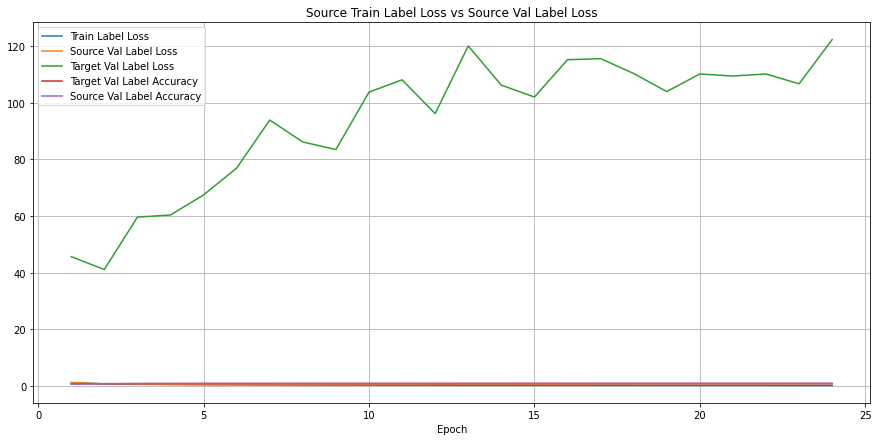

In [25]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

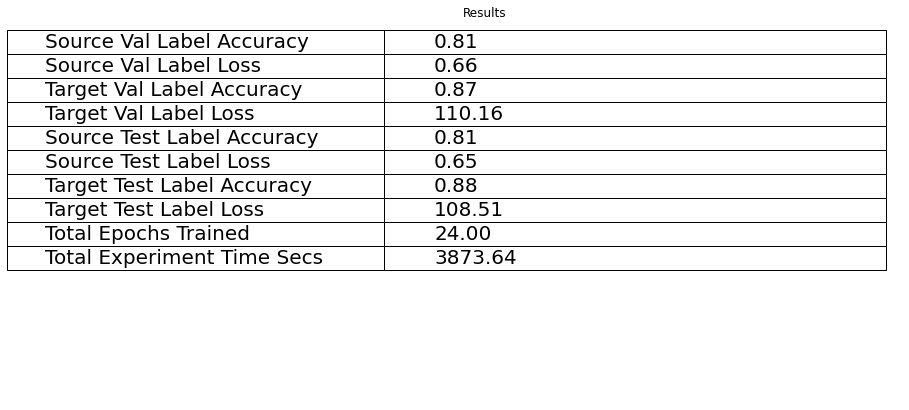

In [26]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

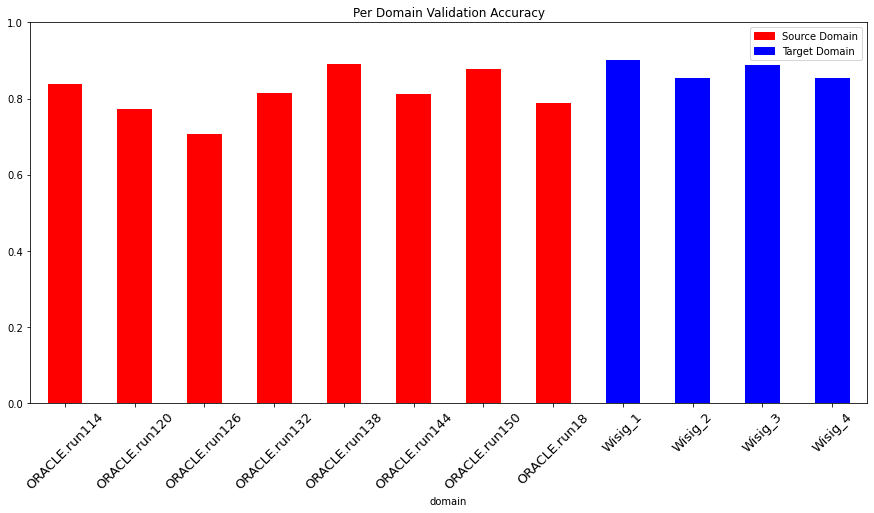

In [27]:
get_domain_accuracies(experiment)

In [28]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.8136067708333333 Target Test Label Accuracy: 0.8768439440993789
Source Val Label Accuracy: 0.81259765625 Target Val Label Accuracy: 0.8739098837209303


In [29]:
json.dumps(experiment)

'{"experiment_name": "tl_1v2:wisig-oracle.run1.limited", "parameters": {"experiment_name": "tl_1v2:wisig-oracle.run1.limited", "device": "cuda", "lr": 0.0001, "n_shot": 3, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 256}}, {"class": "Conv2d", "kargs": {"in_channels": 256, "out_channels": 80, "kernel_size": [2, 7], "bias": true, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 80}}, {"class": "Flatten", "kargs": {}}, {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}}